# PCA AND CLUSTERING TECHNIQUES IN PYTHON

## PART I: Principal Component Analysis

### CODE IMPLEMENTATION

In [34]:
# Library Imports
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from seaborn import load_dataset

Seaborn comes with a number of built-in datasets.
To get a list of all the ones that are prepackaged, use the `get_dataset_names` method.

In [35]:
print("The available datasets in Seaborn are:", end="\n")
print("*"*30, end="")
for data in sns.get_dataset_names():
    print(data)
    
print("*"*30)

The available datasets in Seaborn are:
******************************anagrams
anscombe
attention
brain_networks
car_crashes
diamonds
dots
dowjones
exercise
flights
fmri
geyser
glue
healthexp
iris
mpg
penguins
planets
seaice
taxis
tips
titanic
******************************


> For ease of simplicity when it comes to visualization, the mpg/mtcars dataset shall be used to demonstrate PCA.

We'd also like to see how the various attributes contribute to the principal components

In [36]:
# Create the mpg dataset
mpg = load_dataset(name='mpg')
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [37]:
mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


Let's do a little bit of exploration to understand what this dataset has.

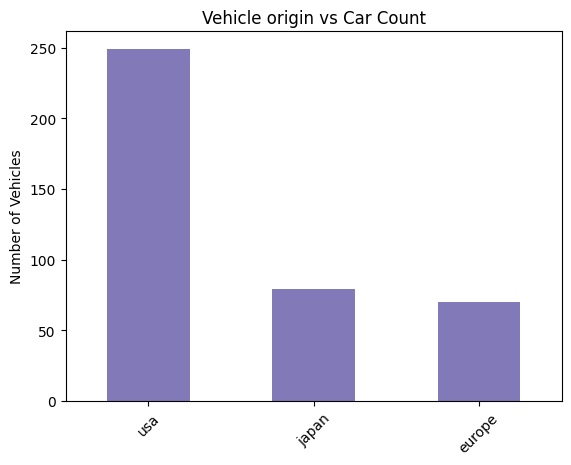

In [38]:
# How many regions does the dataset encompass?
dataLabels, countries = mpg['origin'].value_counts().values, mpg['origin'].value_counts().index

ax = mpg['origin'].value_counts().plot(kind='bar', color='#8179B8')
ax.set_title('Vehicle origin vs Car Count')
ax.set_ylabel('Number of Vehicles')
ax.set_xticklabels(labels=countries, rotation=45);

In [43]:
# Any remarkable stats for vehicles manufactured in each region?

mpg

AttributeError: 'DataFrame' object has no attribute 'group_by'

## PART II: CLUSTERING TECHNIQUES

### AGGLOMERATIVE CLUSTERING

### HIERACHICAL CLUSTERING

### t-SNE

## CONCLUSION